In [41]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv,global_add_pool
from torch_geometric.explain import GNNExplainer, Explainer

In [4]:
dataset = TUDataset(root='.',name='MUTAG').shuffle()

Processing...
Done!


In [5]:
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset = dataset[int(len(dataset)*0.9):]

In [12]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True)

In [13]:
import torch
torch.manual_seed(0) #토치의 난수생성 시드 고정
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_add_pool

class GIN(torch.nn.Module):
    def __init__(self,dim_h):
        super(GIN,self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features,dim_h),
                              BatchNorm1d(dim_h),
                              ReLU(),
                              Linear(dim_h,dim_h),
                              ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h,dim_h),
                              BatchNorm1d(dim_h),
                              ReLU(),
                              Linear(dim_h,dim_h),
                              ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h,dim_h),
                              BatchNorm1d(dim_h),
                              ReLU(),
                              Linear(dim_h,dim_h),
                              ReLU()))
        self.lin1 = Linear(dim_h*3,dim_h*3)
        self.lin2 = Linear(dim_h*3,dataset.num_classes)

    def forward(self,x,edge_index,batch):
        # 노드 임베딩
        h1 = self.conv1(x,edge_index) # 1홉의 정보를 반영한 모든 노드 임베딩
        h2 = self.conv2(h1,edge_index) # 2홉
        h3 = self.conv3(h2,edge_index) # 3홉

        h1 = global_add_pool(h1,batch) # 배치는 그래프의 구분 정보를 암시
        h2 = global_add_pool(h2,batch)
        h3 = global_add_pool(h3,batch)

        #그래프 임베딩으로 표현
        h = torch.cat((h1,h2,h3),dim=1)

        #분류 신경망
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h,p=0.5,training=self.training)
        h = self.lin2(h)
        
        return h


In [17]:
model = GIN(dim_h=32)

In [18]:
print(model)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=96, out_features=96, bias=True)
  (lin2): Linear(in_features=96, out_features=2, bias=True)
)


In [19]:
def accuracy(y_pred,y):
    return ((y_pred==y).sum() / len(y)).item()

In [20]:
@torch.no_grad()
def test(model,loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss,acc = 0,0
    batch_size,total_graphs = 0,0
    for data in loader:
        out = model(data.x,data.edge_index,data.batch)
        batch_size = data.num_graphs
        total_graphs+=batch_size
        loss += criterion(out,data.y).item() * batch_size
        acc += accuracy(out.argmax(dim=1),data.y) * batch_size
    
    return loss/total_graphs, acc/total_graphs

In [21]:
def train(model,loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss,total_acc,val_loss,val_acc = 0,0,0,0
        total_graph = 0
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x,data.edge_index,data.batch)
            loss = criterion(out,data.y) # 하나의 로스, 스칼라 값이 나옴. (평균)
            batch_size = data.num_graphs # 배치 크기
            total_graph+=batch_size # 배치 크기 누적
            total_loss += loss.item()*batch_size
            total_acc += accuracy(out.argmax(dim=1),data.y) * batch_size
            loss.backward()
            optimizer.step()

        val_loss,val_acc = test(model,val_loader)
        
        total_loss /= total_graph
        total_acc /= total_graph
        
        if epoch%20==0:
            print(f'Epoch : {epoch:>3} | Train_loss : {total_loss:.3f} | Train_acc : {total_acc*100:.3f} | Val_loss : {val_loss:.3f} | Val_acc : {val_acc*100:.3f}')

    return model            



In [22]:
model = train(model,train_loader)
test_loss,test_acc = test(model,test_loader)
print(f'Test_Loss : {test_loss:.3f} | Test_Acc : {test_acc:.3f}')

Epoch :   0 | Train_loss : 1.650 | Train_acc : 56.000 | Val_loss : 0.443 | Val_acc : 68.421
Epoch :  20 | Train_loss : 0.386 | Train_acc : 83.333 | Val_loss : 0.293 | Val_acc : 84.211
Epoch :  40 | Train_loss : 0.397 | Train_acc : 80.000 | Val_loss : 0.571 | Val_acc : 84.211
Epoch :  60 | Train_loss : 0.277 | Train_acc : 89.333 | Val_loss : 0.377 | Val_acc : 89.474
Epoch :  80 | Train_loss : 0.208 | Train_acc : 91.333 | Val_loss : 0.267 | Val_acc : 94.737
Epoch : 100 | Train_loss : 0.185 | Train_acc : 91.333 | Val_loss : 0.374 | Val_acc : 89.474
Test_Loss : 0.246 | Test_Acc : 0.789


In [48]:
explainer = Explainer(
    model=model,                          # 학습한 GNN 모델
    algorithm=GNNExplainer(epochs=100),   # GNNExplainer 설정
    explanation_type='model',
    node_mask_type='attributes',          
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification', # 'multiclass_classification' or 'binary_classification'
        task_level='graph',               # ★ 그래프 분류
        return_type='raw',          # model 출력 형태에 맞게
    ),
)


In [52]:
data = dataset[-1]

# 1) 모델이 이 그래프에 대해 어떤 클래스를 예측했는지 먼저 구함
logits = model(data.x, data.edge_index, data.batch)  # [1, num_classes] 가정
pred = logits.argmax(dim=1).item()                  # 예측 클래스 index

# 2) Explainer는 키워드 인자로 + target까지 꼭 줘야 함
e = explainer(
    x=data.x,
    edge_index=data.edge_index,
    batch=data.batch,
    target=pred,     # 이 클래스로 분류된 "이유"를 설명해줘
)

feature_mask, edge_mask = e.node_mask, e.edge_mask

/var/folders/n9/654ym8ws0_j1lt2gmvbm6k2w0000gn/T/ipykernel_5214/1157263438.py:8: UserWarning: The 'target' should not be provided for the explanation type 'model'
  e = explainer(


In [56]:
feature_mask

tensor([[0.3484, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3069, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3420, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3126, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2821, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8037, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7550, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7777, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2930, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3106, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3389, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2861, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0

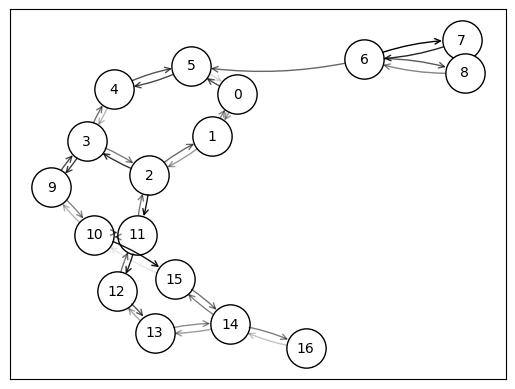

In [68]:
sub_e = e.get_explanation_subgraph()
sub_e.visualize_graph(backend='networkx')